**Lorenz**

$$
\begin{array}{l}
\dot{x}=10(y-x),\\
\dot{y}=x(28-z)-y,\\
\dot{z}=xy-\frac{8}{3}z.
\end{array}
$$

$$
\begin{bmatrix}
x_0 & y_0 & z_0
\end{bmatrix}^T
=
\begin{bmatrix}
-8 & 7 & 27
\end{bmatrix}^T
$$




### 原始代码  
BsplineKANLayer

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# from deepkan import SplineLinearLayer
from BKAN import SplineLinearLayer
import random
from torch import autograd
from tqdm import tqdm
import os
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import nodepy.linear_multistep_method as lm
import torch.nn as nn
import torch.optim as optim


# Define the custom KAN layer
class KANLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 num_knots=10, spline_order=3, 
                 noise_scale=0.1, base_scale=1.0, 
                 spline_scale=1.0, activation=nn.SiLU, 
                 grid_epsilon=0.02, grid_range=[-50, 50]):
        super(KANLayer, self).__init__()
        self.linear = SplineLinearLayer(in_features, out_features, num_knots, 
                                        spline_order, noise_scale, base_scale, 
                                        spline_scale, activation, grid_epsilon, grid_range)

    def forward(self, x):
        return self.linear(x)

# Define the combined model
class KANModel(nn.Module):
    def __init__(self):
        super(KANModel, self).__init__()
        self.kan_layer1 = KANLayer(3 ,7)    
        # self.ln1 = nn.Tanh()
        # self.ln1 = nn.Sigmoid()
        self.kan_layer2 = KANLayer(7, 3)  

    def forward(self, x):
        x = x.view(-1, 3)  # Flatten the input tensor
        x = self.kan_layer1(x)
        x = self.kan_layer2(x)
        return x
    
torch.set_default_dtype(torch.float64) # 设置默认张量数据类型为双精度浮点数

Epoch 1/6000, Train_loss:  4.1429853857634036e-01
Epoch 1001/6000, Train_loss:  1.6781313793366097e-04
Epoch 2001/6000, Train_loss:  6.6230343398899900e-05
Epoch 3001/6000, Train_loss:  5.3782398647037772e-05
Epoch 4001/6000, Train_loss:  3.5809519944831468e-05
Epoch 5001/6000, Train_loss:  2.9985485849261466e-05


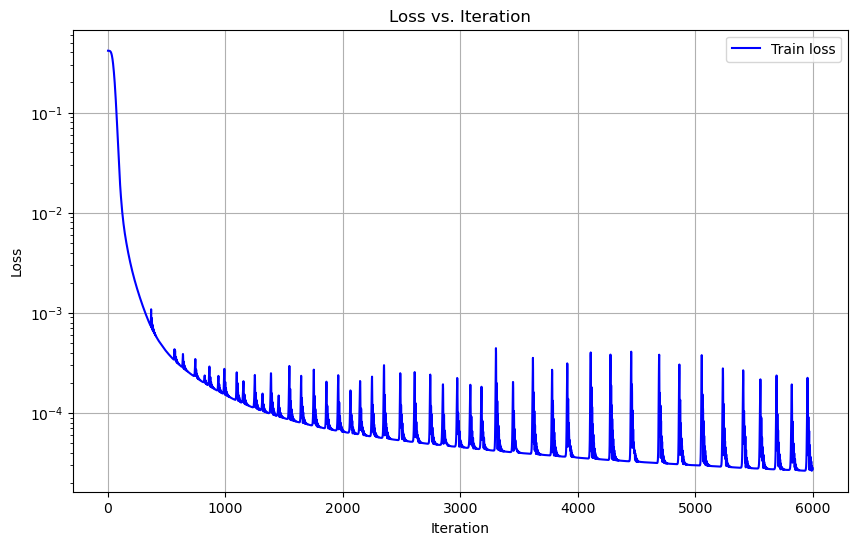

In [2]:
import random
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import os
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import nodepy.linear_multistep_method as lm
import torch.nn as nn
import torch.optim as optim


torch.set_default_dtype(torch.float64) # 设置默认张量数据类型为双精度浮点数

torch.manual_seed(0)
# 超参数
n_steps = 2000          # 样本取点数     
noise = 0                # 样本点的噪声
steps = 6000             # 迭代次数
M = 1                    # 多步法的步数


# initial condition
y0 = np.array([-8.0, 7.0, 27]).flatten()

# 均匀取点
# t_np = 2*(np.logspace(start=-2, stop=1, num=n_steps, endpoint=True))-0.02
t_np = np.linspace(0, 20, num=n_steps)

# 自适应取点方式

# 随机取点方式
# np.random.seed(0)
# h = 10
# t_np = np.random.rand(n_steps)*h


# T = torch.from_numpy(t_np)
# t_1 = torch.stack([T.reshape(-1,)]).permute(1,0)


dt = t_np[M] - t_np[0]   # 步长

# function that returns dx/dt
def f(x,t): # x is 3 x 1
    sigma = 10.0
    beta = 8.0/3.0
    rho = 28.0
    
    f1 = sigma*(x[1]-x[0])
    f2 = x[0]*(rho-x[2])-x[1]
    f3 = x[0]*x[1]-beta*x[2]
    f = np.array([f1,f2,f3])
    return f

def f_ivp(t, x):
    return f(x, t)


# 计算出微分方程的数值解，它使用 lsoda 方法进行数值积分，lsoda 方法使用了 Gear 公式的变步长、变阶数实现。它是一种隐式的多步法
# y_np = odeint(f, y0, t_np) 
t_span = (t_np[0], t_np[-1])
sol = solve_ivp(f_ivp, t_span, y0, method='RK45', t_eval=t_np)
y_np = sol.y.T

# # 计算微分方程的真实解
# y_np1 = source_fun_1(torch.from_numpy(t_np))
# y_np2= source_fun_2(torch.from_numpy(t_np))
# y_np = torch.stack([y_np1, y_np2], axis=1).numpy()

y_train = y_np[0::M,:]
# y_train = y_train + noise*y_train.std(0)*np.random.randn(y_train.shape[0], y_train.shape[1])
y_train = y_train + noise*np.random.randn(y_train.shape[0], y_train.shape[1])

model = KANModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.05,betas=(0.9, 0.999),  eps=1e-32)
# optimizer = LBFGS(model.parameters(), lr=0.05, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

def net_Y(alpha,beta,T,y_train_new):
    Y = alpha[0] * T[:, M:, :] + dt * beta[0] * model(y_train_new[M:, :]).unsqueeze(0)
    for m in range(1, M + 1):
        Y = Y + alpha[m] * T[:, M-m:-m, :] + dt * beta[m] * model(y_train_new[M-m:-m, :]).unsqueeze(0) # S x (N-M+1) x D
    return Y


# 用于存储每次迭代的损失值
Train_loss_list = []
iteration_list = []

for epoch in range(steps):
    model.train()
    scheme = 'AM'
        # Load weights
    switch = {'AM': lm.Adams_Moulton,
                'AB': lm.Adams_Bashforth,
                'BDF': lm.backward_difference_formula}
    method = switch[scheme](M)

    # 将 method.alpha 和 method.beta 转换为浮点数数组
    alpha = torch.tensor(-np.array(method.alpha[::-1], dtype=np.float32))
    beta = torch.tensor(np.array(method.beta[::-1], dtype=np.float32))

    y_train_new  = torch.tensor(y_train)
    T = y_train_new.unsqueeze(0)
    optimizer.zero_grad()
    Y_pred = net_Y(alpha,beta,T,y_train_new)
    loss = criterion(Y_pred, torch.zeros_like(Y_pred))
    loss.backward()
    optimizer.step()


    # 存储损失值和迭代次数
    Train_loss_list.append(loss.cpu().detach().numpy())
    iteration_list.append(epoch)



    if epoch % 1000 == 0:
        print(f'Epoch {epoch+1}/{steps}, Train_loss: {loss.item(): .16e}')

plt.figure(figsize=(10, 6))
plt.plot(iteration_list, Train_loss_list, label='Train loss', color='b')
plt.yscale('log')
# plt.ylim(10e-10, 10e1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_steps = n_steps
test_np = np.linspace(0, 20, test_steps)


def predict_f(y_star):
    y_star_tensor = torch.tensor(y_star)
    with torch.no_grad():
        F_star = model(y_star_tensor)
    return F_star.numpy()


def learned_f(x,t):
    f = predict_f(x[None,:])
    return f.flatten()


learned_X_star = odeint(learned_f, y0, test_np)    

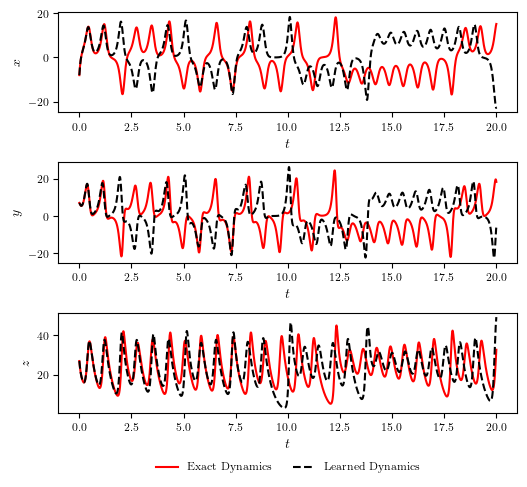

In [5]:
from plotting import newfig, savefig
import matplotlib.gridspec as gridspec
####### Plotting ##################

fig, ax = newfig(1.0, 1.5)
ax.axis('off')

gs0 = gridspec.GridSpec(3, 1)
gs0.update(top=0.95, bottom=0.15, left=0.1, right=0.95, hspace=0.5)

ax = plt.subplot(gs0[0:1, 0:1])
ax.plot(t_np,y_np[:,0],'r-')
ax.plot(t_np,learned_X_star[:,0],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')

ax = plt.subplot(gs0[1:2, 0:1])
ax.plot(t_np,y_np[:,1],'r-')
ax.plot(t_np,learned_X_star[:,1],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$y$')

ax = plt.subplot(gs0[2:3, 0:1])
ax.plot(t_np,y_np[:,2],'r-',label='Exact Dynamics')
ax.plot(t_np,learned_X_star[:,2],'k--',label='Learned Dynamics')
ax.set_xlabel('$t$')
ax.set_ylabel('$z$')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=2, frameon=False)

# savefig('./figures/Lorenz_Traj', crop = False)
plt.savefig('Trajectory_Lorenz.pdf', bbox_inches='tight', pad_inches=0)

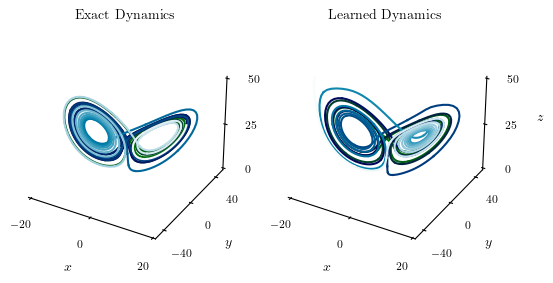

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


def colorline3d(ax, x, y, z, cmap):
    N = len(x)
    skip = int(0.01*N)
    for i in range(0,N,skip):
        ax.plot(x[i:i+skip+1], y[i:i+skip+1], z[i:i+skip+1], color=cmap(int(255*i/N)))
        
####### Plotting ################## 
fig, ax = newfig(1.0, 0.8)
ax.axis('off')

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=0.95, bottom=0.1, left=0.0, right=0.90, wspace=0.15)

ax = plt.subplot(gs0[:, 0:1], projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
colorline3d(ax, y_np[:,0], y_np[:,1], y_np[:,2], cmap = plt.cm.ocean)
ax.grid(False)
ax.set_xlim([-20,20])
ax.set_ylim([-50,50])
ax.set_zlim([0,50])
ax.set_xticks([-20,0,20])
ax.set_yticks([-40,0,40])
ax.set_zticks([0,25,50])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Exact Dynamics', fontsize = 10)

ax = plt.subplot(gs0[:, 1:2], projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))    
colorline3d(ax, learned_X_star[:,0], learned_X_star[:,1], learned_X_star[:,2], cmap = plt.cm.ocean)
ax.grid(False)
ax.set_xlim([-20,20])
ax.set_ylim([-50,50])
ax.set_zlim([0,50])
ax.set_xticks([-20,0,20])
ax.set_yticks([-40,0,40])
ax.set_zticks([0,25,50])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Learned Dynamics', fontsize = 10)
# plt.savefig('Phase_Lorenz.pdf', bbox_inches='tight', pad_inches=0)
